# Cat classification

Установим torchmetrics, чтобы руками не считать точность.

In [ ]:
!pip install torchvision torchmetrics

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Normalize, ToTensor

from torchmetrics import Accuracy as VAccuracy
from tqdm import tqdm
import random


def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

## Dataset

Cклонируем с гитхаба датасет.

In [4]:
!git clone https://github.com/fortvivlan/catset.git
# %cd catset if run locally 
%cd content/catset
!ls

fatal: destination path 'catset' already exists and is not an empty directory.
/home/linora/CODE/Python/RSUH/ragurepa/sem04/catset
Cats  cats.ipynb  README.md


Напишем функцию, которая будет сплитить наш датасет: сперва отшаффлим индексы и разделим их стандартной ск-лерновской тулзой, а потом воспользуемся утилитой торча Subset.

In [3]:
%cd catset
dataset = datasets.ImageFolder('Cats')

/home/linora/CODE/Python/RSUH/ragurepa/sem04/catset


Разбиваем датасет на:
1. Трейн (70%) - на чем модель будет учиться;
2. Валидацию (15%) - на чем мы будем оценивать гиперпараметры модели и выбирать наилучшую модель;
3. Тест (15%) - для оценки качества наилучшей модели.

In [4]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.70, 0.15, 0.15], generator=torch.Generator().manual_seed(42))

Теперь надо подготовить датасет к работе.

## Preprocessing

Во-превых, картинки в батче нужно превратить в тензоры, потому что нейросеть работает с тензорами. Благо, нам мне нужно итерироваться по датасету, загружать все свои тяжелые картинки в оперативную память и ручками кастовать их к тензорам - торч умеет делать это за нас, причём гораздо эффективнее.

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dummy_dataset = datasets.ImageFolder('Cats', transform=transform)

Во-вторых, картинки неплохо бы нормализовать: помним, что любая картинка эссеншали только матрица с чиселками. Сделаем наши картинки не слишком яркими, чтобы все они были примерно одинаковыми по интенсивности цвета и подобное. Для этого нужно предпосчитать среднее и стандартное отклонение по датасету.

**Важно:** среднее и дисперсию оцениваем только на основе трейна и валидации, т.к. это тоже своего рода гиперпараметры, которые ни в коем случае не должны знать про тестовую выборку! 

In [6]:
def estimate_mean_std(dataset) -> tuple[float]:
    '''Calculate channelwise mean and std for dataset'''
        
    channels_sum, channels_squared_sum, num_pixels = 0, 0, 0
    for sample, _ in dataset: # sample - картинка, _ - класс картинки
        sample = transforms.ToTensor()(sample)
        # channels_sum - сумма пикселей по каждому каналу (всего три канала)
        channels_sum += torch.sum(sample, dim=[1, 2]) # [3 x height x width]
        channels_squared_sum += torch.sum(sample ** 2, dim=[1, 2])
        # число пикселей в картинке
        num_pixels += sample.size(1) * sample.size(2)

    mean = channels_sum / num_pixels

    std = (channels_squared_sum / num_pixels - mean ** 2) ** 0.5

    return mean, std

In [7]:
mean, std = estimate_mean_std(train_dataset)
mean, std

(tensor([0.3895, 0.3667, 0.3412]), tensor([0.2726, 0.2694, 0.2655]))

Получили нужные чиселки: теперь нужно добавить их в трансформацию, которую будем использовать уже в реальной подготовке датасета.

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
dataset = datasets.ImageFolder('Cats', transform=transform)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.70, 0.15, 0.15], generator=torch.Generator().manual_seed(42))

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

Ну вот, теперь поставка данных готова, пора писать трейнлуп и архитектурку.

## Model

In [10]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(1, n_epochs + 1):
        # train
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train) # используем кросс-энтропию
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # validation
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f"Epoch: {epoch}\tloss: {np.mean(val_loss)}\taccuracy: {np.mean(val_accuracy)}")

In [11]:
class Torchic(nn.Module):
    def __init__(self):
        super().__init__()
        # VGG
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) # 3 канала, 10 ядер, размер ядра - 5
        # картинка сожмется на x - (kernel_size - 1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # картинка сожмется на x - (kernel_size - 1)
        self.pool = nn.MaxPool2d(2) # макс-пулинг: уменьшим на 2
        # картинка сожмется в два раза
        self.flatten = nn.Flatten()

        # head
        # исходные картинки были 256х256х3. После первого слоя сверток стало: 252х252х10)
        # после второго слоя сверток стало: 248х248х20
        # после пулинга стало 124х124х20
        self.fc1 = nn.Linear(124 * 124 * 20, 128) # слой на 128 нейронов
        self.fc2 = nn.Linear(128, 2) # выходной слой на 2 нейрона (можно было 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
set_random_seed(123)
torchic = Torchic()
optimizer = opt.Adam(torchic.parameters(), lr=0.001)

In [15]:
train(torchic, optimizer, 6)

100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


Epoch: 2	loss: 0.7346521615982056	accuracy: 0.5416666666666666


100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


Epoch: 4	loss: 0.7305289506912231	accuracy: 0.7083333333333334


100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

Epoch: 6	loss: 0.7015055418014526	accuracy: 0.7916666666666666


In [16]:
def matplotlib_imshow(img, one_channel=False):
    """A function for plotting unnormalized images, but it still gets clipping warning"""
    if one_channel:
        img = img.mean(dim=0)
    img = img * std + mean
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (0, 1, 2)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


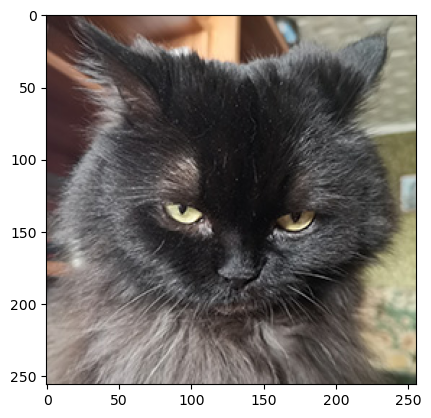

Dat is Мороша
Torchic thinks it is Мороша


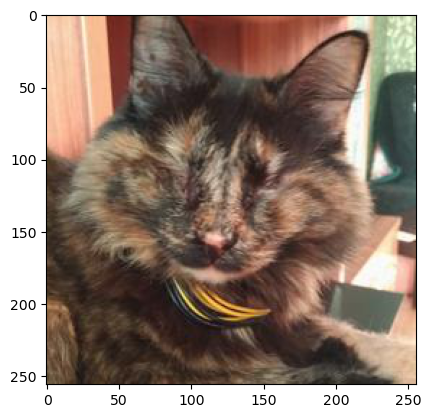

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Лисена
Torchic thinks it is Мороша


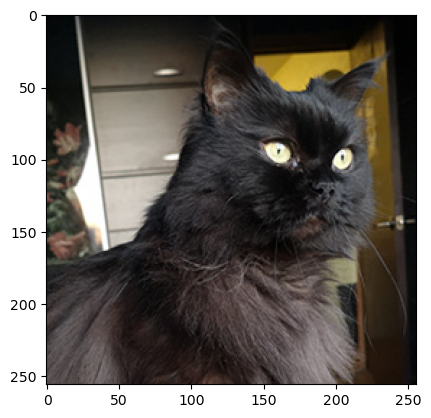

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Мороша
Torchic thinks it is Мороша


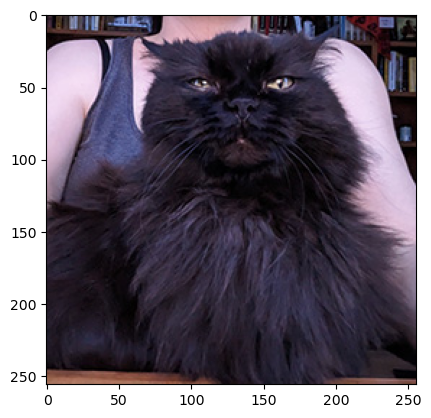

Dat is Мороша
Torchic thinks it is Мороша


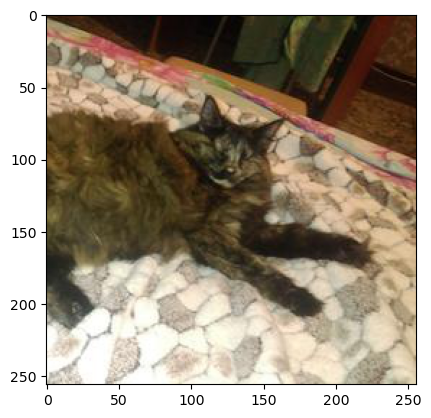

Dat is Лисена
Torchic thinks it is Лисена


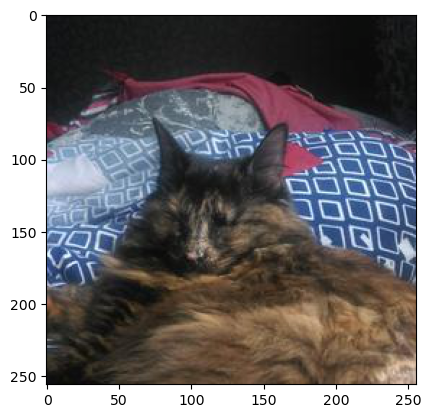

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Лисена
Torchic thinks it is Мороша


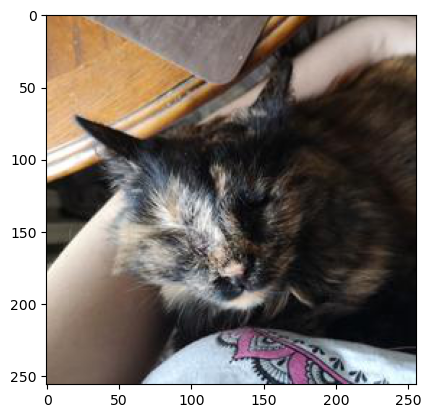

Dat is Лисена
Torchic thinks it is Лисена


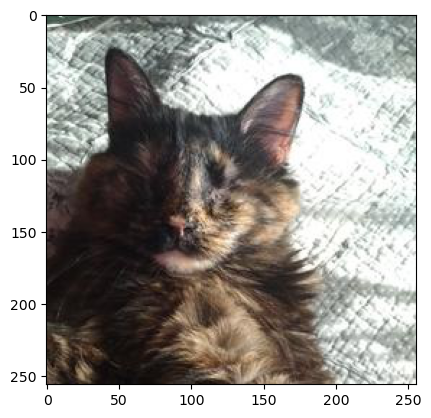

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Лисена
Torchic thinks it is Лисена


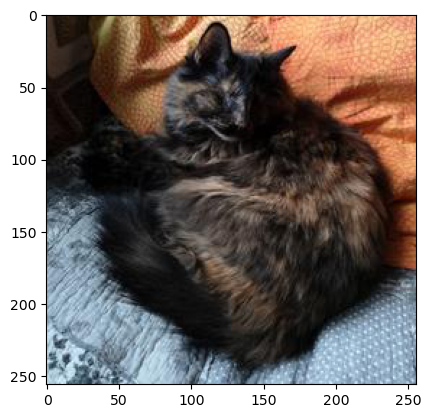

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Лисена
Torchic thinks it is Лисена


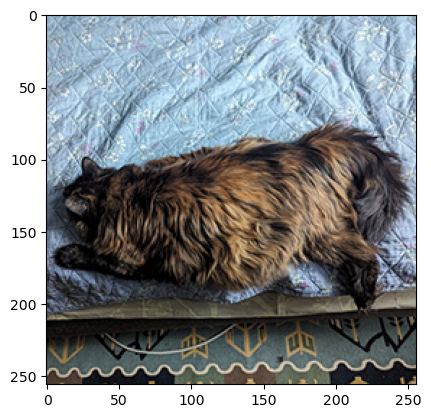

Dat is Лисена
Torchic thinks it is Лисена


In [17]:
classes = {0: 'Лисена', 1: 'Мороша'}

torchic.eval()
for i in range(10):
    img, label = test_dataset[i]
    # нам здесь приходится перевернуть, чтобы обратно разнормализовать нашу картинку
    matplotlib_imshow(img.permute(1, 2, 0))
    plt.show()
    print(f"Dat is {classes[label]}")
    ypred = torchic(img.unsqueeze(0))
    print(f"Torchic thinks it is {classes[torch.argmax(ypred, dim=-1).item()]}")